In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
# Define some handy network layers
def lrelu(x, rate=0.1):
    return tf.maximum(tf.minimum(x * rate, 0), x)

def conv2d_lrelu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d(inputs, num_outputs, kernel_size, stride, 
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    conv = lrelu(conv)
    return conv

def conv2d_t_relu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d_transpose(inputs, num_outputs, kernel_size, stride,
                                                     weights_initializer=tf.contrib.layers.xavier_initializer(),
                                                     activation_fn=tf.identity)
    conv = tf.nn.relu(conv)
    return conv

def fc_lrelu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = lrelu(fc)
    return fc

def fc_relu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(),
                                           activation_fn=tf.identity)
    fc = tf.nn.relu(fc)
    return fc

In [3]:
# Encoder and decoder use the DC-GAN architecture
# 28 x 28 x 1
def encoder(x, z_dim):
    with tf.variable_scope('encoder'):
        conv1 = conv2d_lrelu(x, 64, 4, 2)   # None x 14 x 14 x 64
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)   # None x 7 x 7 x 128
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])]) # None x (7x7x128)
        fc1 = fc_lrelu(conv2, 1024)   
        mean = tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)
        stddev = tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.sigmoid)
        stddev = tf.maximum(stddev, 0.005)
        return mean, stddev

In [4]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
        fc1 = fc_relu(z, 1024)
        fc2 = fc_relu(fc1, 7*7*128)
        fc2 = tf.reshape(fc2, tf.stack([tf.shape(fc2)[0], 7, 7, 128]))
        conv1 = conv2d_t_relu(fc2, 64, 4, 2)
        mean = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        stddev = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        stddev = tf.maximum(stddev, 0.005)
        return mean, stddev

In [5]:
# Build the computation graph for training
z_dim = 20
x_dim = [28, 28, 1]
train_x = tf.placeholder(tf.float32, shape=[None] + x_dim)
train_zmean, train_zstddev = encoder(train_x, z_dim)
train_z =  train_zmean + tf.multiply(train_zstddev,
                                     tf.random_normal(tf.stack([tf.shape(train_x)[0], z_dim])))
zstddev_logdet = tf.reduce_mean(tf.reduce_sum(2.0 * tf.log(train_zstddev), axis=1))

train_xmean, train_xstddev = decoder(train_z)
train_xr = train_xmean + tf.multiply(train_xstddev,
                                     tf.random_normal(tf.stack([tf.shape(train_x)[0]] + x_dim)))
xstddev_logdet = tf.reduce_mean(tf.reduce_sum(2.0 * tf.log(train_xstddev), axis=(1, 2, 3)))

In [6]:
# Build the computation graph for generating samples
gen_z = tf.placeholder(tf.float32, shape=[None, z_dim])
gen_x, gen_xstddev = decoder(gen_z, reuse=True)

In [7]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):   # [batch_size, z_dim] [batch_size, z_dim]
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

# Compare the generated z with true samples from a standard Gaussian, and compute their MMD distance
true_samples = tf.random_normal(tf.stack([200, z_dim]))
loss_mmd = compute_mmd(true_samples, train_z)

In [8]:
loss_elbo = tf.reduce_sum(-tf.log(train_zstddev) + 0.5 * tf.square(train_zstddev) +
                          0.5 * tf.square(train_zmean) - 0.5, axis=1)
loss_elbo = tf.reduce_mean(loss_elbo) / np.prod(x_dim)

In [9]:
loss_nll = tf.div(tf.square(train_x - train_xmean), tf.square(train_xstddev)) / 2.0 + tf.log(train_xstddev)
loss_nll = tf.reduce_mean(loss_nll)
loss_nll += math.log(2 * np.pi) / 2.0

In [10]:
loss = loss_nll + loss_elbo
trainer = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_data')

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [12]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples, max_samples=100):
    if max_samples > samples.shape[0]:
        max_samples = samples.shape[0]
    cnt, height, width = int(math.floor(math.sqrt(max_samples))), samples.shape[1], samples.shape[2]
    samples = samples[:cnt*cnt]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [13]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
batch_size = 100
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True))
sess.run(tf.global_variables_initializer())

Negative log likelihood is 0.688513, mmd loss is 0.001990


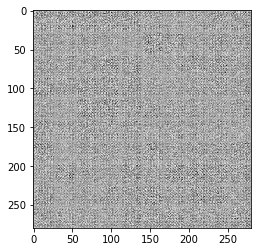

Negative log likelihood is -0.898827, mmd loss is 0.316509
Negative log likelihood is -1.357819, mmd loss is 0.295573
Negative log likelihood is -1.214798, mmd loss is 0.195940
Negative log likelihood is -1.773496, mmd loss is 0.173886
Negative log likelihood is -1.782029, mmd loss is 0.121098


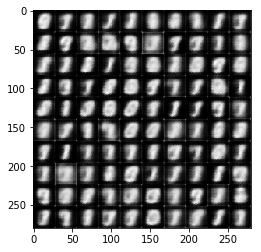

Negative log likelihood is -2.052240, mmd loss is 0.084907
Negative log likelihood is -2.072839, mmd loss is 0.065933
Negative log likelihood is -2.432086, mmd loss is 0.084937
Negative log likelihood is -2.436934, mmd loss is 0.068328
Negative log likelihood is -2.582242, mmd loss is 0.042564


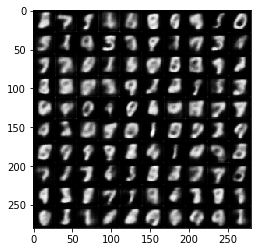

Negative log likelihood is -2.498206, mmd loss is 0.032518
Negative log likelihood is -2.593208, mmd loss is 0.051240
Negative log likelihood is -2.617148, mmd loss is 0.023671
Negative log likelihood is -2.691241, mmd loss is 0.036392
Negative log likelihood is -2.681007, mmd loss is 0.040459


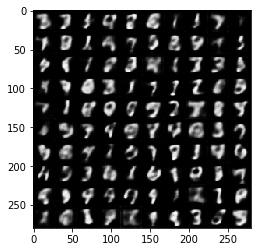

Negative log likelihood is -2.634483, mmd loss is 0.038048
Negative log likelihood is -2.710342, mmd loss is 0.022325
Negative log likelihood is -2.841751, mmd loss is 0.024364
Negative log likelihood is -2.864903, mmd loss is 0.019266
Negative log likelihood is -2.811946, mmd loss is 0.025038


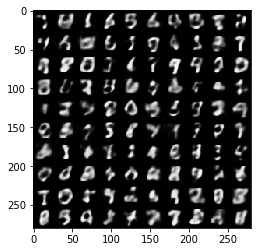

Negative log likelihood is -2.902509, mmd loss is 0.025019
Negative log likelihood is -2.766956, mmd loss is 0.019731
Negative log likelihood is -2.952652, mmd loss is 0.022027
Negative log likelihood is -2.986547, mmd loss is 0.017710
Negative log likelihood is -2.975080, mmd loss is 0.014680


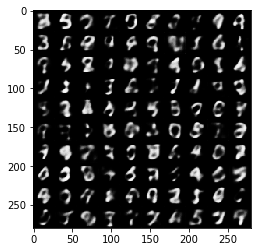

Negative log likelihood is -2.910138, mmd loss is 0.024448
Negative log likelihood is -2.930660, mmd loss is 0.020922
Negative log likelihood is -3.001077, mmd loss is 0.015415
Negative log likelihood is -3.087693, mmd loss is 0.023521
Negative log likelihood is -3.006704, mmd loss is 0.017018


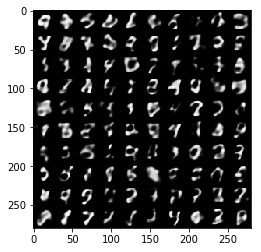

Negative log likelihood is -3.064415, mmd loss is 0.014297
Negative log likelihood is -3.076336, mmd loss is 0.015623
Negative log likelihood is -3.013143, mmd loss is 0.016494
Negative log likelihood is -3.032152, mmd loss is 0.017562
Negative log likelihood is -3.038737, mmd loss is 0.012044


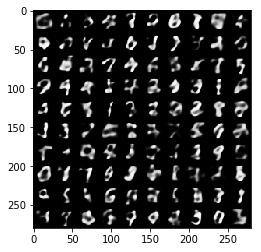

Negative log likelihood is -3.025570, mmd loss is 0.014392
Negative log likelihood is -3.030986, mmd loss is 0.014954
Negative log likelihood is -3.114216, mmd loss is 0.014334
Negative log likelihood is -3.065221, mmd loss is 0.011411
Negative log likelihood is -3.141879, mmd loss is 0.014255


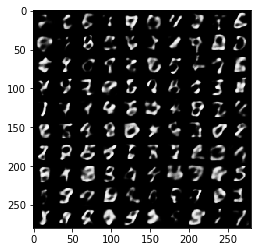

Negative log likelihood is -3.186003, mmd loss is 0.010779
Negative log likelihood is -3.190962, mmd loss is 0.012159
Negative log likelihood is -3.129451, mmd loss is 0.017406
Negative log likelihood is -3.223758, mmd loss is 0.009679
Negative log likelihood is -3.124204, mmd loss is 0.010010


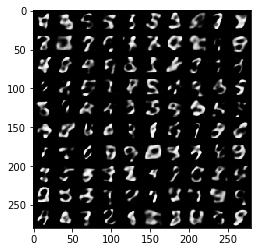

Negative log likelihood is -3.186177, mmd loss is 0.009442
Negative log likelihood is -3.186650, mmd loss is 0.008776
Negative log likelihood is -3.202991, mmd loss is 0.010606
Negative log likelihood is -3.208479, mmd loss is 0.012884
Negative log likelihood is -3.172964, mmd loss is 0.013260


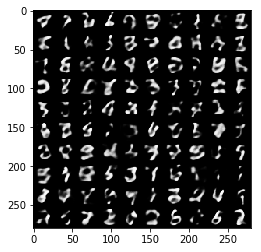

Negative log likelihood is -3.236152, mmd loss is 0.009195
Negative log likelihood is -3.253125, mmd loss is 0.011232
Negative log likelihood is -3.209126, mmd loss is 0.010324
Negative log likelihood is -3.215290, mmd loss is 0.011692
Negative log likelihood is -3.226573, mmd loss is 0.010039


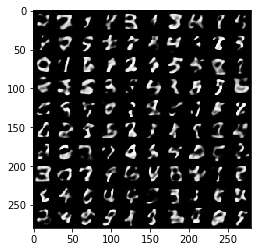

Negative log likelihood is -3.252827, mmd loss is 0.009144
Negative log likelihood is -3.309414, mmd loss is 0.006468
Negative log likelihood is -3.326994, mmd loss is 0.008131
Negative log likelihood is -3.148002, mmd loss is 0.010981
Negative log likelihood is -3.255892, mmd loss is 0.008328


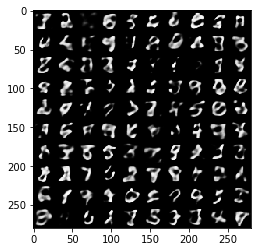

Negative log likelihood is -3.235518, mmd loss is 0.008492
Negative log likelihood is -3.213947, mmd loss is 0.011961
Negative log likelihood is -3.269908, mmd loss is 0.010162
Negative log likelihood is -3.247389, mmd loss is 0.008365
Negative log likelihood is -3.259662, mmd loss is 0.011871


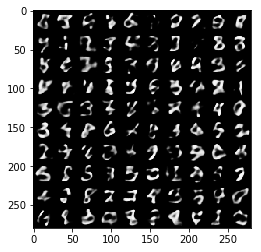

Negative log likelihood is -3.262299, mmd loss is 0.008030
Negative log likelihood is -3.308053, mmd loss is 0.010075
Negative log likelihood is -3.380411, mmd loss is 0.008975
Negative log likelihood is -3.327622, mmd loss is 0.010540
Negative log likelihood is -3.286378, mmd loss is 0.008736


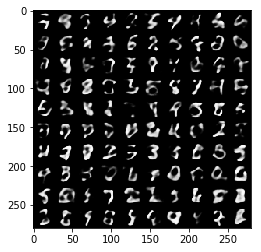

Negative log likelihood is -3.337215, mmd loss is 0.007291
Negative log likelihood is -3.369765, mmd loss is 0.007007
Negative log likelihood is -3.353826, mmd loss is 0.004578
Negative log likelihood is -3.204341, mmd loss is 0.008617
Negative log likelihood is -3.355598, mmd loss is 0.007590


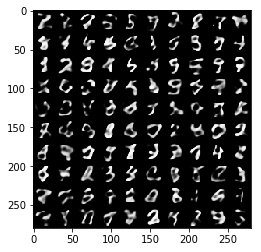

Negative log likelihood is -3.357651, mmd loss is 0.005199
Negative log likelihood is -3.287013, mmd loss is 0.006951
Negative log likelihood is -3.274375, mmd loss is 0.006431
Negative log likelihood is -3.309700, mmd loss is 0.007435
Negative log likelihood is -3.353993, mmd loss is 0.010381


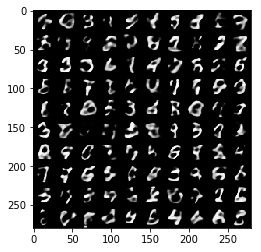

Negative log likelihood is -3.350410, mmd loss is 0.006292
Negative log likelihood is -3.415317, mmd loss is 0.009130
Negative log likelihood is -3.468912, mmd loss is 0.005497
Negative log likelihood is -3.337815, mmd loss is 0.005107
Negative log likelihood is -3.307490, mmd loss is 0.007126


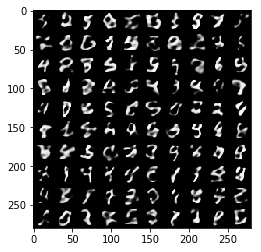

Negative log likelihood is -3.366505, mmd loss is 0.007545
Negative log likelihood is -3.354205, mmd loss is 0.005982
Negative log likelihood is -3.327853, mmd loss is 0.008264
Negative log likelihood is -3.330062, mmd loss is 0.005420
Negative log likelihood is -3.343312, mmd loss is 0.008286


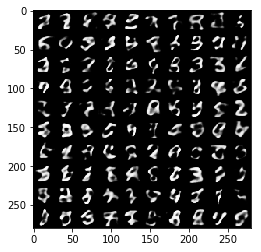

Negative log likelihood is -3.304780, mmd loss is 0.005826
Negative log likelihood is -3.362150, mmd loss is 0.007746
Negative log likelihood is -3.357028, mmd loss is 0.008345
Negative log likelihood is -3.410002, mmd loss is 0.004637
Negative log likelihood is -3.356412, mmd loss is 0.005335


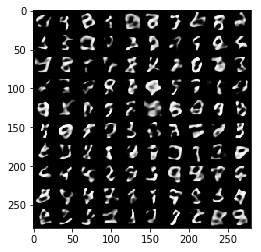

Negative log likelihood is -3.355769, mmd loss is 0.004745
Negative log likelihood is -3.371647, mmd loss is 0.007514
Negative log likelihood is -3.411612, mmd loss is 0.004550
Negative log likelihood is -3.410086, mmd loss is 0.005410
Negative log likelihood is -3.371763, mmd loss is 0.007647


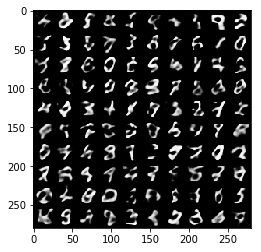

Negative log likelihood is -3.363506, mmd loss is 0.007696
Negative log likelihood is -3.420490, mmd loss is 0.005613
Negative log likelihood is -3.444499, mmd loss is 0.005179
Negative log likelihood is -3.421641, mmd loss is 0.006159
Negative log likelihood is -3.345731, mmd loss is 0.005196


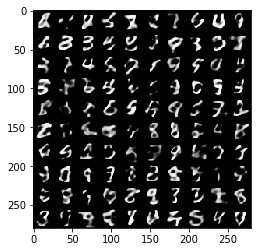

Negative log likelihood is -3.415221, mmd loss is 0.006490
Negative log likelihood is -3.424951, mmd loss is 0.006274
Negative log likelihood is -3.426743, mmd loss is 0.005020
Negative log likelihood is -3.325931, mmd loss is 0.007478
Negative log likelihood is -3.412372, mmd loss is 0.005815


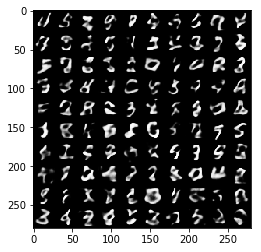

Negative log likelihood is -3.456186, mmd loss is 0.003725
Negative log likelihood is -3.474850, mmd loss is 0.006691
Negative log likelihood is -3.417156, mmd loss is 0.005742
Negative log likelihood is -3.426036, mmd loss is 0.005874
Negative log likelihood is -3.403620, mmd loss is 0.004390


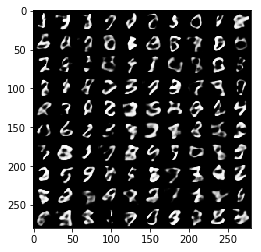

Negative log likelihood is -3.421695, mmd loss is 0.004506
Negative log likelihood is -3.399084, mmd loss is 0.003257
Negative log likelihood is -3.421475, mmd loss is 0.005548
Negative log likelihood is -3.396793, mmd loss is 0.006146
Negative log likelihood is -3.418189, mmd loss is 0.004026


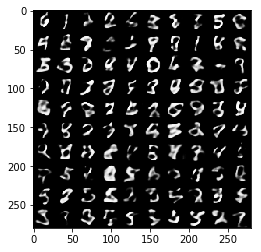

Negative log likelihood is -3.393631, mmd loss is 0.005043
Negative log likelihood is -3.456754, mmd loss is 0.006114
Negative log likelihood is -3.492636, mmd loss is 0.006366
Negative log likelihood is -3.403312, mmd loss is 0.005386
Negative log likelihood is -3.477434, mmd loss is 0.003637


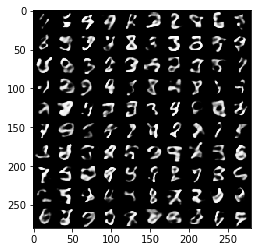

Negative log likelihood is -3.487910, mmd loss is 0.006008
Negative log likelihood is -3.477126, mmd loss is 0.004252
Negative log likelihood is -3.457942, mmd loss is 0.005193
Negative log likelihood is -3.375088, mmd loss is 0.004903
Negative log likelihood is -3.405548, mmd loss is 0.004772


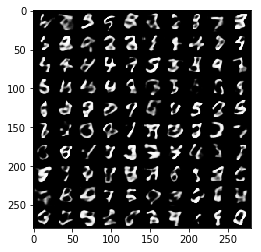

Negative log likelihood is -3.470078, mmd loss is 0.003325
Negative log likelihood is -3.405108, mmd loss is 0.003576
Negative log likelihood is -3.472980, mmd loss is 0.004084
Negative log likelihood is -3.429492, mmd loss is 0.004628
Negative log likelihood is -3.474389, mmd loss is 0.003321


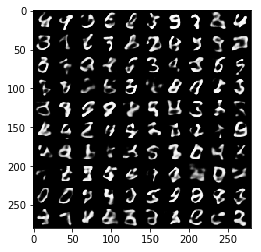

Negative log likelihood is -3.456510, mmd loss is 0.003816
Negative log likelihood is -3.498499, mmd loss is 0.005344
Negative log likelihood is -3.474389, mmd loss is 0.002703
Negative log likelihood is -3.473038, mmd loss is 0.003977
Negative log likelihood is -3.490888, mmd loss is 0.003401


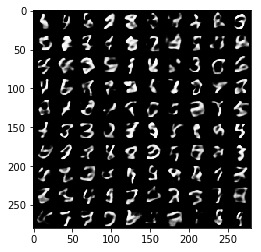

Negative log likelihood is -3.464349, mmd loss is 0.003952
Negative log likelihood is -3.463995, mmd loss is 0.003035
Negative log likelihood is -3.415153, mmd loss is 0.004868
Negative log likelihood is -3.460202, mmd loss is 0.004836
Negative log likelihood is -3.542617, mmd loss is 0.003649


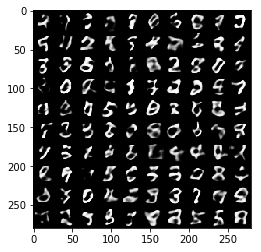

Negative log likelihood is -3.428659, mmd loss is 0.002989
Negative log likelihood is -3.509787, mmd loss is 0.004460
Negative log likelihood is -3.395013, mmd loss is 0.003375
Negative log likelihood is -3.504039, mmd loss is 0.004788
Negative log likelihood is -3.473977, mmd loss is 0.002621


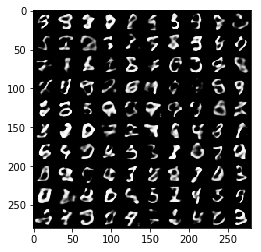

Negative log likelihood is -3.411583, mmd loss is 0.003274
Negative log likelihood is -3.494517, mmd loss is 0.002830
Negative log likelihood is -3.416611, mmd loss is 0.005068
Negative log likelihood is -3.437442, mmd loss is 0.002472
Negative log likelihood is -3.459364, mmd loss is 0.002983


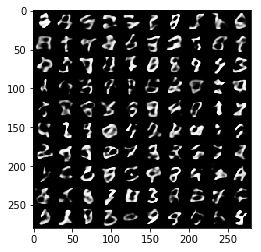

Negative log likelihood is -3.514385, mmd loss is 0.003412
Negative log likelihood is -3.455520, mmd loss is 0.005221
Negative log likelihood is -3.458328, mmd loss is 0.004428
Negative log likelihood is -3.499970, mmd loss is 0.003421
Negative log likelihood is -3.468096, mmd loss is 0.002858


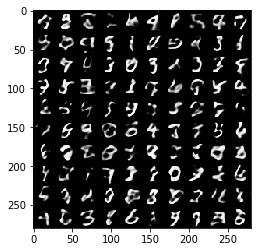

Negative log likelihood is -3.441221, mmd loss is 0.003529
Negative log likelihood is -3.442554, mmd loss is 0.003777
Negative log likelihood is -3.440430, mmd loss is 0.004483
Negative log likelihood is -3.461664, mmd loss is 0.003046
Negative log likelihood is -3.488110, mmd loss is 0.002879


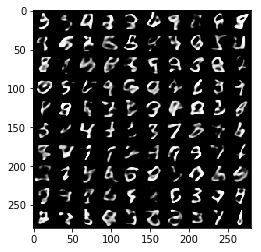

Negative log likelihood is -3.506837, mmd loss is 0.003474
Negative log likelihood is -3.507442, mmd loss is 0.004495
Negative log likelihood is -3.498090, mmd loss is 0.004252
Negative log likelihood is -3.431014, mmd loss is 0.004025
Negative log likelihood is -3.485209, mmd loss is 0.003068


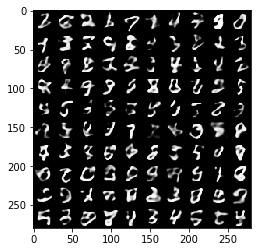

Negative log likelihood is -3.480837, mmd loss is 0.003132
Negative log likelihood is -3.429121, mmd loss is 0.003808
Negative log likelihood is -3.471234, mmd loss is 0.002455
Negative log likelihood is -3.475289, mmd loss is 0.002774
Negative log likelihood is -3.501675, mmd loss is 0.003332


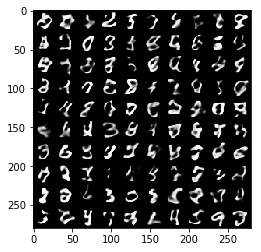

Negative log likelihood is -3.524705, mmd loss is 0.002550
Negative log likelihood is -3.486146, mmd loss is 0.002432
Negative log likelihood is -3.494062, mmd loss is 0.003521
Negative log likelihood is -3.496810, mmd loss is 0.002493
Negative log likelihood is -3.494974, mmd loss is 0.002969


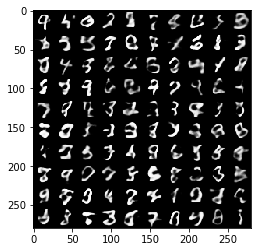

Negative log likelihood is -3.477682, mmd loss is 0.002605
Negative log likelihood is -3.507098, mmd loss is 0.003432
Negative log likelihood is -3.551860, mmd loss is 0.003104
Negative log likelihood is -3.521663, mmd loss is 0.003236
Negative log likelihood is -3.520825, mmd loss is 0.002989


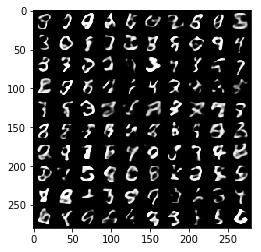

Negative log likelihood is -3.527293, mmd loss is 0.003046
Negative log likelihood is -3.530970, mmd loss is 0.002694
Negative log likelihood is -3.563653, mmd loss is 0.004086
Negative log likelihood is -3.519237, mmd loss is 0.003313
Negative log likelihood is -3.440220, mmd loss is 0.001928


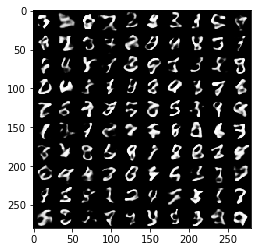

Negative log likelihood is -3.496006, mmd loss is 0.002865
Negative log likelihood is -3.462981, mmd loss is 0.002905
Negative log likelihood is -3.497001, mmd loss is 0.001770
Negative log likelihood is -3.515417, mmd loss is 0.002692
Negative log likelihood is -3.476675, mmd loss is 0.004512


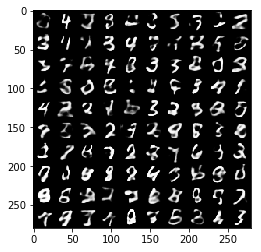

Negative log likelihood is -3.490234, mmd loss is 0.002732
Negative log likelihood is -3.510420, mmd loss is 0.002423
Negative log likelihood is -3.504632, mmd loss is 0.001281
Negative log likelihood is -3.513588, mmd loss is 0.003062
Negative log likelihood is -3.541338, mmd loss is 0.002701


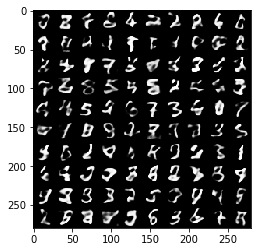

Negative log likelihood is -3.516013, mmd loss is 0.003714
Negative log likelihood is -3.473371, mmd loss is 0.001960
Negative log likelihood is -3.524133, mmd loss is 0.003113
Negative log likelihood is -3.462413, mmd loss is 0.004209
Negative log likelihood is -3.464248, mmd loss is 0.003199


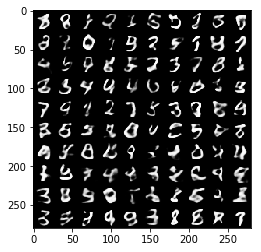

Negative log likelihood is -3.560915, mmd loss is 0.003254
Negative log likelihood is -3.520968, mmd loss is 0.002925
Negative log likelihood is -3.512840, mmd loss is 0.002775
Negative log likelihood is -3.528338, mmd loss is 0.001902
Negative log likelihood is -3.573876, mmd loss is 0.002224


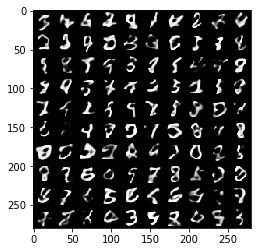

Negative log likelihood is -3.495533, mmd loss is 0.002331
Negative log likelihood is -3.557120, mmd loss is 0.001699
Negative log likelihood is -3.470310, mmd loss is 0.003303
Negative log likelihood is -3.489769, mmd loss is 0.001833
Negative log likelihood is -3.519356, mmd loss is 0.002609


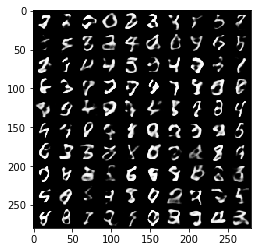

Negative log likelihood is -3.515741, mmd loss is 0.002450
Negative log likelihood is -3.546585, mmd loss is 0.001915
Negative log likelihood is -3.542541, mmd loss is 0.002518
Negative log likelihood is -3.527026, mmd loss is 0.003100
Negative log likelihood is -3.491908, mmd loss is 0.002839


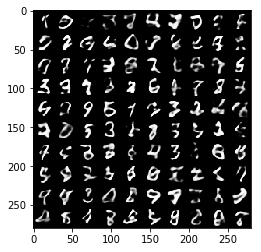

Negative log likelihood is -3.533575, mmd loss is 0.002966
Negative log likelihood is -3.533392, mmd loss is 0.001883
Negative log likelihood is -3.526104, mmd loss is 0.002506
Negative log likelihood is -3.582799, mmd loss is 0.002111
Negative log likelihood is -3.504520, mmd loss is 0.002196


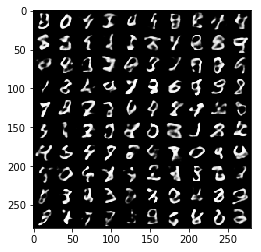

Negative log likelihood is -3.544619, mmd loss is 0.003084
Negative log likelihood is -3.546779, mmd loss is 0.002298
Negative log likelihood is -3.533154, mmd loss is 0.002852
Negative log likelihood is -3.495396, mmd loss is 0.003727
Negative log likelihood is -3.517255, mmd loss is 0.001341


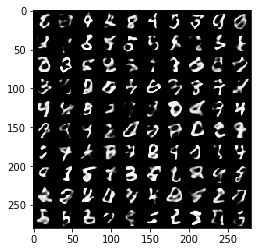

Negative log likelihood is -3.530325, mmd loss is 0.001285
Negative log likelihood is -3.566353, mmd loss is 0.003119
Negative log likelihood is -3.576105, mmd loss is 0.001894
Negative log likelihood is -3.412604, mmd loss is 0.002713
Negative log likelihood is -3.556376, mmd loss is 0.002771


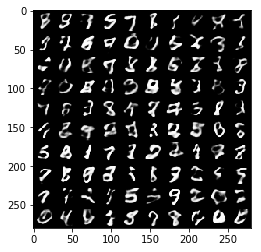

Negative log likelihood is -3.577872, mmd loss is 0.002287
Negative log likelihood is -3.577127, mmd loss is 0.002041
Negative log likelihood is -3.527385, mmd loss is 0.002715
Negative log likelihood is -3.489781, mmd loss is 0.003423
Negative log likelihood is -3.566292, mmd loss is 0.003078


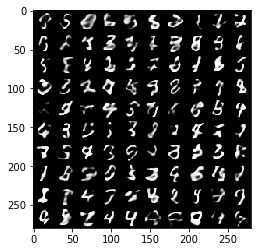

Negative log likelihood is -3.573886, mmd loss is 0.002512
Negative log likelihood is -3.546522, mmd loss is 0.001931
Negative log likelihood is -3.539293, mmd loss is 0.001519
Negative log likelihood is -3.556962, mmd loss is 0.003024
Negative log likelihood is -3.531621, mmd loss is 0.002628


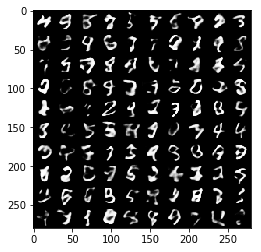

Negative log likelihood is -3.581467, mmd loss is 0.001645
Negative log likelihood is -3.541312, mmd loss is 0.001275
Negative log likelihood is -3.551874, mmd loss is 0.003857
Negative log likelihood is -3.463906, mmd loss is 0.002742
Negative log likelihood is -3.541695, mmd loss is 0.002642


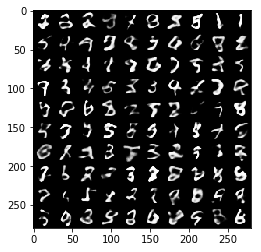

Negative log likelihood is -3.565761, mmd loss is 0.002907
Negative log likelihood is -3.615935, mmd loss is 0.002618
Negative log likelihood is -3.564583, mmd loss is 0.001518
Negative log likelihood is -3.560719, mmd loss is 0.001761
Negative log likelihood is -3.598813, mmd loss is 0.001786


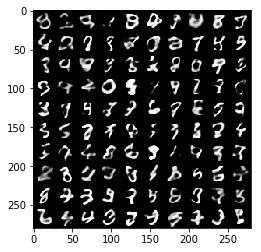

Negative log likelihood is -3.593750, mmd loss is 0.003649
Negative log likelihood is -3.541990, mmd loss is 0.002249
Negative log likelihood is -3.536180, mmd loss is 0.002353
Negative log likelihood is -3.556615, mmd loss is 0.001980
Negative log likelihood is -3.524291, mmd loss is 0.002318


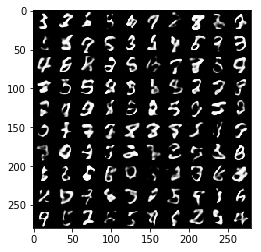

Negative log likelihood is -3.535568, mmd loss is 0.002333
Negative log likelihood is -3.582075, mmd loss is 0.002845
Negative log likelihood is -3.537176, mmd loss is 0.002291
Negative log likelihood is -3.539773, mmd loss is 0.002547
Negative log likelihood is -3.555057, mmd loss is 0.003387


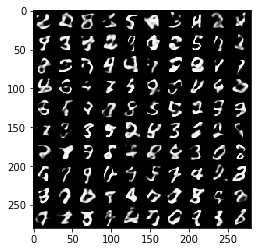

Negative log likelihood is -3.573711, mmd loss is 0.002607
Negative log likelihood is -3.578036, mmd loss is 0.001541
Negative log likelihood is -3.612124, mmd loss is 0.002698
Negative log likelihood is -3.525267, mmd loss is 0.002132
Negative log likelihood is -3.549458, mmd loss is 0.003222


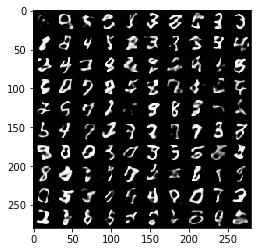

Negative log likelihood is -3.463789, mmd loss is 0.002214
Negative log likelihood is -3.511992, mmd loss is 0.001777
Negative log likelihood is -3.579783, mmd loss is 0.001089
Negative log likelihood is -3.611386, mmd loss is 0.001930
Negative log likelihood is -3.569979, mmd loss is 0.002442


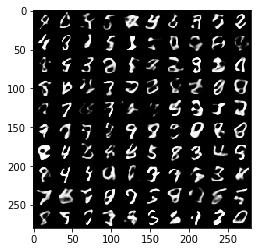

Negative log likelihood is -3.576083, mmd loss is 0.002249
Negative log likelihood is -3.520057, mmd loss is 0.002621
Negative log likelihood is -3.478009, mmd loss is 0.003099
Negative log likelihood is -3.581332, mmd loss is 0.002487
Negative log likelihood is -3.595760, mmd loss is 0.001993


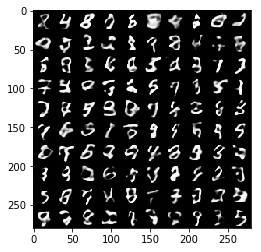

Negative log likelihood is -3.535206, mmd loss is 0.002051
Negative log likelihood is -3.583967, mmd loss is 0.002666
Negative log likelihood is -3.594888, mmd loss is 0.001967
Negative log likelihood is -3.548419, mmd loss is 0.001253
Negative log likelihood is -3.521042, mmd loss is 0.002427


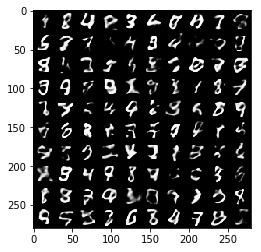

Negative log likelihood is -3.590564, mmd loss is 0.002695
Negative log likelihood is -3.601069, mmd loss is 0.002559
Negative log likelihood is -3.569544, mmd loss is 0.002101
Negative log likelihood is -3.553256, mmd loss is 0.002293
Negative log likelihood is -3.595307, mmd loss is 0.001924


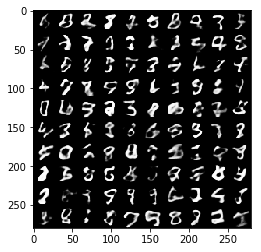

Negative log likelihood is -3.552176, mmd loss is 0.002827
Negative log likelihood is -3.496162, mmd loss is 0.002712
Negative log likelihood is -3.590075, mmd loss is 0.001999
Negative log likelihood is -3.582617, mmd loss is 0.001602
Negative log likelihood is -3.556298, mmd loss is 0.003495


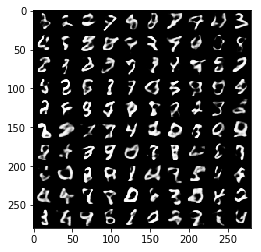

Negative log likelihood is -3.492152, mmd loss is 0.003251
Negative log likelihood is -3.550153, mmd loss is 0.002000
Negative log likelihood is -3.590485, mmd loss is 0.002234
Negative log likelihood is -3.593586, mmd loss is 0.002291
Negative log likelihood is -3.567693, mmd loss is 0.002079


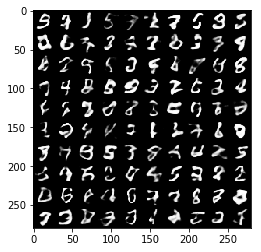

Negative log likelihood is -3.544937, mmd loss is 0.001574
Negative log likelihood is -3.549564, mmd loss is 0.001951
Negative log likelihood is -3.583276, mmd loss is 0.002398
Negative log likelihood is -3.583066, mmd loss is 0.001377
Negative log likelihood is -3.555063, mmd loss is 0.001332


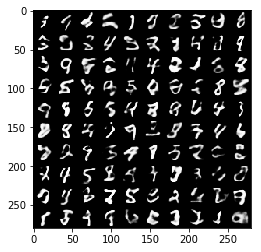

Negative log likelihood is -3.581308, mmd loss is 0.003274
Negative log likelihood is -3.575330, mmd loss is 0.002607
Negative log likelihood is -3.582687, mmd loss is 0.001744
Negative log likelihood is -3.576142, mmd loss is 0.002013
Negative log likelihood is -3.580651, mmd loss is 0.003150


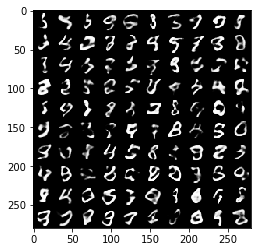

Negative log likelihood is -3.587138, mmd loss is 0.001955
Negative log likelihood is -3.569889, mmd loss is 0.001682
Negative log likelihood is -3.610008, mmd loss is 0.002781
Negative log likelihood is -3.565831, mmd loss is 0.003173
Negative log likelihood is -3.584641, mmd loss is 0.002340


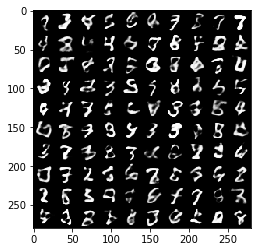

Negative log likelihood is -3.570651, mmd loss is 0.002137
Negative log likelihood is -3.603949, mmd loss is 0.001863
Negative log likelihood is -3.573522, mmd loss is 0.001850
Negative log likelihood is -3.604375, mmd loss is 0.001153
Negative log likelihood is -3.601379, mmd loss is 0.001630


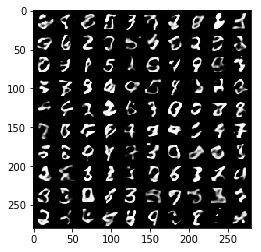

Negative log likelihood is -3.549732, mmd loss is 0.002120
Negative log likelihood is -3.581072, mmd loss is 0.000839
Negative log likelihood is -3.558685, mmd loss is 0.001945
Negative log likelihood is -3.604806, mmd loss is 0.002235
Negative log likelihood is -3.603974, mmd loss is 0.001417


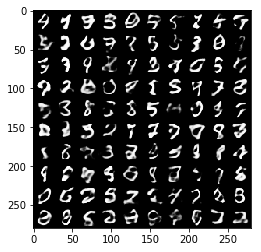

Negative log likelihood is -3.581873, mmd loss is 0.001221
Negative log likelihood is -3.595798, mmd loss is 0.001711
Negative log likelihood is -3.595140, mmd loss is 0.002274
Negative log likelihood is -3.593643, mmd loss is 0.001363
Negative log likelihood is -3.541171, mmd loss is 0.002966


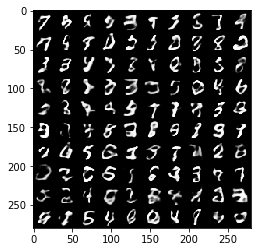

Negative log likelihood is -3.635264, mmd loss is 0.002238
Negative log likelihood is -3.560794, mmd loss is 0.001886
Negative log likelihood is -3.591110, mmd loss is 0.001907
Negative log likelihood is -3.557045, mmd loss is 0.002382
Negative log likelihood is -3.633811, mmd loss is 0.001031


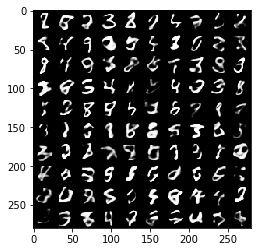

Negative log likelihood is -3.602279, mmd loss is 0.001356
Negative log likelihood is -3.617755, mmd loss is 0.001901
Negative log likelihood is -3.609500, mmd loss is 0.001678
Negative log likelihood is -3.568652, mmd loss is 0.002642
Negative log likelihood is -3.575382, mmd loss is 0.001096


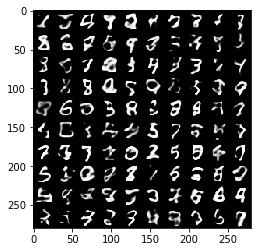

Negative log likelihood is -3.630091, mmd loss is 0.002154
Negative log likelihood is -3.551083, mmd loss is 0.003571
Negative log likelihood is -3.581349, mmd loss is 0.002359
Negative log likelihood is -3.604598, mmd loss is 0.003700
Negative log likelihood is -3.640126, mmd loss is 0.003774


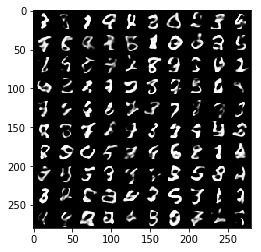

Negative log likelihood is -3.609244, mmd loss is 0.002871
Negative log likelihood is -3.592029, mmd loss is 0.001263
Negative log likelihood is -3.598372, mmd loss is 0.002298
Negative log likelihood is -3.465984, mmd loss is 0.001438
Negative log likelihood is -3.604467, mmd loss is 0.001350


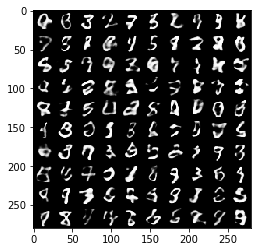

Negative log likelihood is -3.641131, mmd loss is 0.001492
Negative log likelihood is -3.571699, mmd loss is 0.003570
Negative log likelihood is -3.557877, mmd loss is 0.001277
Negative log likelihood is -3.594934, mmd loss is 0.001773
Negative log likelihood is -3.496420, mmd loss is 0.002816


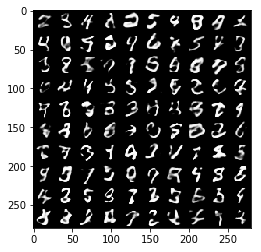

Negative log likelihood is -3.524612, mmd loss is 0.001770
Negative log likelihood is -3.576261, mmd loss is 0.001693
Negative log likelihood is -3.621028, mmd loss is 0.002243
Negative log likelihood is -3.574778, mmd loss is 0.001707
Negative log likelihood is -3.597963, mmd loss is 0.002737


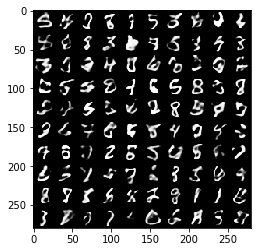

Negative log likelihood is -3.311613, mmd loss is 0.003124
Negative log likelihood is -3.484711, mmd loss is 0.002334
Negative log likelihood is -3.525051, mmd loss is 0.002011
Negative log likelihood is -3.551090, mmd loss is 0.002097
Negative log likelihood is -3.550939, mmd loss is 0.001755


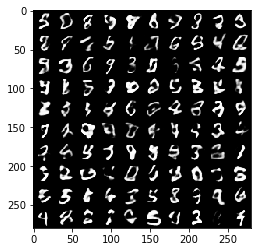

Negative log likelihood is -3.607122, mmd loss is 0.001816
Negative log likelihood is -3.579546, mmd loss is 0.001595
Negative log likelihood is -3.599916, mmd loss is 0.002296
Negative log likelihood is -3.618784, mmd loss is 0.003236
Negative log likelihood is -3.547202, mmd loss is 0.001452


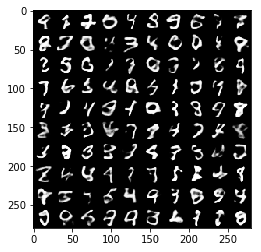

Negative log likelihood is -3.639800, mmd loss is 0.001678
Negative log likelihood is -3.582204, mmd loss is 0.002667
Negative log likelihood is -3.603050, mmd loss is 0.002600
Negative log likelihood is -3.634672, mmd loss is 0.001841
Negative log likelihood is -3.591502, mmd loss is 0.002006


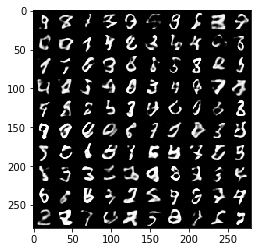

Negative log likelihood is -3.638990, mmd loss is 0.001875
Negative log likelihood is -3.618375, mmd loss is 0.002343
Negative log likelihood is -3.639517, mmd loss is 0.001543
Negative log likelihood is -3.607241, mmd loss is 0.003294
Negative log likelihood is -3.584836, mmd loss is 0.002171


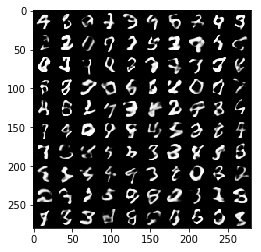

Negative log likelihood is -3.633286, mmd loss is 0.001704
Negative log likelihood is -3.627529, mmd loss is 0.002343
Negative log likelihood is -3.616980, mmd loss is 0.002220
Negative log likelihood is -3.606308, mmd loss is 0.001465
Negative log likelihood is -3.583984, mmd loss is 0.001631


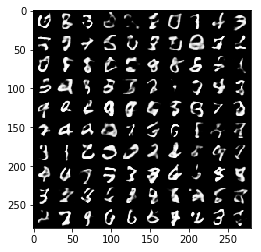

Negative log likelihood is -3.558226, mmd loss is 0.002210
Negative log likelihood is -3.637698, mmd loss is 0.001983
Negative log likelihood is -3.607241, mmd loss is 0.001998
Negative log likelihood is -3.596982, mmd loss is 0.002923
Negative log likelihood is -3.581318, mmd loss is 0.001614


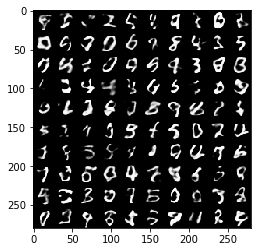

Negative log likelihood is -3.631986, mmd loss is 0.003970
Negative log likelihood is -3.645772, mmd loss is 0.001488
Negative log likelihood is -3.628674, mmd loss is 0.001580
Negative log likelihood is -3.605786, mmd loss is 0.002684
Negative log likelihood is -3.604366, mmd loss is 0.001364


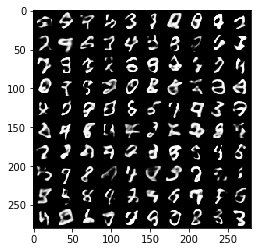

Negative log likelihood is -3.622114, mmd loss is 0.001610
Negative log likelihood is -3.629227, mmd loss is 0.002028
Negative log likelihood is -3.597532, mmd loss is 0.001607
Negative log likelihood is -3.597611, mmd loss is 0.002572


In [14]:
# Start training
for i in range(40000):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    _, nll, mmd = sess.run([trainer, loss_nll, loss_mmd], feed_dict={train_x: batch_x})
    if i % 100 == 0:
        print("Negative log likelihood is %f, mmd loss is %f" % (nll, mmd))
    if i % 500 == 0:
        samples = sess.run(gen_x, feed_dict={gen_z: np.random.normal(size=(100, z_dim))})
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()

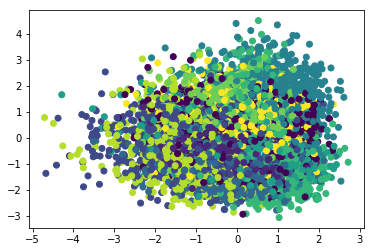

In [15]:
z_list, label_list = [], []
test_batch_size = 500
for i in range(20):
    batch_x, batch_y = mnist.test.next_batch(test_batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    z_list.append(sess.run(train_z, feed_dict={train_x: batch_x}))
    label_list.append(batch_y)
z = np.concatenate(z_list, axis=0)
label = np.concatenate(label_list)
plt.scatter(z[:, 0], z[:, 1], c=label)
plt.show()

In [16]:
def semi_supervised_learning(train_feature, train_label, test_feature, test_label):
    # Compute pair-wise distance
    x_range = np.sqrt(np.sum(np.square(np.max(train_feature, axis=0) - np.min(train_feature, axis=0))))
    gamma = 0.0001 / x_range
    optimal_gamma = gamma
    optimal_accuracy = 0
    while True:
        classifier = svm.SVC(decision_function_shape='ovr', gamma=gamma)
        classifier.fit(train_feature, train_label)

        pred = classifier.predict(test_feature)
        correct_count = np.sum([1 for j in range(test_feature.shape[0]) if test_label[j] == pred[j]])
        if correct_count > optimal_accuracy:
            optimal_accuracy = correct_count
            optimal_gamma = gamma
        # print("%f %d" % (gamma, correct_count))
        gamma *= 2.0
        if gamma > 100.0:
            break
    optimal_accuracy /= float(test_feature.shape[0])
    return optimal_accuracy, optimal_gamma

In [17]:
train_features = []
train_labels = []
for j in range(300):
    batch_x, batch_y = mnist.train.next_batch(100)
    batch_x = np.reshape(batch_x, [-1]+x_dim)
    z = sess.run(train_z, feed_dict={train_x: batch_x})
    train_features.append(z)
    train_labels.append(batch_y)
train_feature = np.concatenate(train_features, axis=0)
train_label = np.concatenate(train_labels, axis=0)

In [18]:
test_features = []
test_labels = []
for j in range(100):
    batch_x, batch_y = mnist.test.next_batch(100)
    batch_x = np.reshape(batch_x, [-1]+x_dim)
    z = sess.run(train_z, feed_dict={train_x: batch_x})
    test_features.append(z)
    test_labels.append(batch_y)
test_feature = np.concatenate(test_features, axis=0)
test_label = np.concatenate(test_labels)

In [19]:
from sklearn import svm
import time
start_time = time.time()
accuracy_list = []
num_iter = 50
for j in range(num_iter):
    random_ind = np.random.choice(train_feature.shape[0], size=1000, replace=False)
    accuracy, gamma = semi_supervised_learning(train_feature[random_ind, :], train_label[random_ind], test_feature, test_label)
    accuracy_list.append(accuracy)
    if j % 10 == 0:
        print("Processed %d-th batch for 1000 label semi-supervised learning, time elapsed %f" % (j, time.time() - start_time))
accuracy = np.mean(accuracy_list)

Processed 0-th batch for 1000 label semi-supervised learning, time elapsed 11.921468
Processed 10-th batch for 1000 label semi-supervised learning, time elapsed 127.235075
Processed 20-th batch for 1000 label semi-supervised learning, time elapsed 241.955378
Processed 30-th batch for 1000 label semi-supervised learning, time elapsed 356.577703
Processed 40-th batch for 1000 label semi-supervised learning, time elapsed 471.823159


In [20]:
accuracy

0.95612399999999997

In [21]:
class ComputeLL:
    def __init__(self, z_dim):
        self.mean = tf.placeholder(tf.float32, shape=(None, z_dim))
        self.stddev = tf.placeholder(tf.float32, shape=(None, z_dim))
        self.sample = tf.placeholder(tf.float32, shape=(None, z_dim))
        mu = tf.reshape(self.mean, shape=tf.stack([tf.shape(self.mean)[0], 1, z_dim]))
        mu = tf.tile(mu, tf.stack([1, tf.shape(self.sample)[0], 1]))
        sig = tf.reshape(self.stddev, shape=tf.stack([tf.shape(self.stddev)[0], 1, z_dim]))
        sig = tf.tile(sig, tf.stack([1, tf.shape(self.sample)[0], 1]))
        z = tf.reshape(self.sample, shape=tf.stack([1, tf.shape(self.sample)[0], z_dim]))
        z = tf.tile(z, tf.stack([tf.shape(self.mean)[0], 1, 1]))

        coeff = tf.div(1.0 / math.sqrt(2 * math.pi), sig)
        ll = coeff * tf.exp(-tf.div(tf.square(z - mu), 2 * tf.square(sig)))
        ll = tf.reduce_prod(ll, axis=2)
        self.prob = ll
        
ll_compute = ComputeLL(z_dim)

In [22]:
print("Evaluating Mutual Information")
start_time = time.time()
num_batch = 100
z_batch_cnt = 10  # This must divide num_batch
dist_batch_cnt = 10
assert num_batch % z_batch_cnt == 0
assert num_batch % dist_batch_cnt == 0

sample_batches = np.zeros((num_batch*batch_size, z_dim))
mean_batches = np.zeros((num_batch*batch_size, z_dim))
stddev_batches = np.zeros((num_batch*batch_size, z_dim))
for batch in range(num_batch):
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, [-1]+x_dim)
    sample, z_mean, z_stddev = sess.run([train_z, train_zmean, train_zstddev], feed_dict={train_x: batch_x})
    sample_batches[batch*batch_size:(batch+1)*batch_size, :] = sample
    mean_batches[batch*batch_size:(batch+1)*batch_size, :] = z_mean
    stddev_batches[batch*batch_size:(batch+1)*batch_size, :] = z_stddev

z_batch_size = batch_size * z_batch_cnt
dist_batch_size = batch_size * dist_batch_cnt
prob_array = np.zeros((num_batch*batch_size, num_batch*batch_size), dtype=np.float)
for z_ind in range(num_batch // z_batch_cnt):
    for dist_ind in range(num_batch // dist_batch_cnt):
        mean = mean_batches[dist_ind*dist_batch_size:(dist_ind+1)*dist_batch_size, :]
        stddev = stddev_batches[dist_ind * dist_batch_size:(dist_ind + 1) * dist_batch_size, :]
        sample = sample_batches[z_ind*z_batch_size:(z_ind+1)*z_batch_size, :]
        probs = sess.run(ll_compute.prob, feed_dict={ll_compute.mean: mean,
                                                     ll_compute.stddev: stddev,
                                                     ll_compute.sample: sample})
        prob_array[dist_ind*dist_batch_size:(dist_ind+1)*dist_batch_size, z_ind*z_batch_size:(z_ind+1)*z_batch_size] = probs
    # print()
# print(np.sum(prob_array))
marginal = np.sum(prob_array, axis=0)
ratio = np.log(np.divide(np.diagonal(prob_array), marginal)) + np.log(num_batch*batch_size)
mutual_info = np.mean(ratio)
print("Mutual Information %f, time elapsed %fs" % (mutual_info, time.time() - start_time))

Evaluating Mutual Information
Mutual Information 9.210340, time elapsed 2.548112s
